# Assignment 3: Linear Regression (100 points)

Only use the already imported library `numpy` and the Python standard library. Make sure that the datasets `dataLinReg2D.txt`, `dataQuadReg2D.txt` and `dataQuadReg2D_noisy.txt` are in the same directory as the notebook.


* Adityakrishna Okade (3507212), M.Sc.Infotech
* Simhadri Holagundhi (3508282), M.Sc.Infotech

## Task 1: Linear Regression - theory (10 points)
1) *(4 points)* Linear regression can have nonlinear input features, why is it still called linear regression? In what sense is it linear?

==> In general, linear regression works on the linearity of parameters and not the features, we can keep features as complex as we want. The linearity is not in terms of x but the parameters. We can have a quadratic or square root function but it will be still called 'linear' because the thetas are so.

2) *(3 points)* For calculating optimal parameters $\hat{\beta}$ the inverse of $X^{\top}X$ has to be calculated. When would this matrix be singular?

==> The matrix $X^{\top}X$ would be singular if it's determinant is zero

3) *(3 points)* Why does the optimization problem for $L_1$-regularization (Lasso) not have a closed form solution?

==> L1 regularization norm values leads to sparse solutions ( generally diamond shaped graph ) and not closed form solutions, which might lead one of the lambda values to reach zero thus leading to sparsity.

## Task 2: Ridge Regression for Polynomial 2D Functions (70 points)
Each line in the data sets consists of a data entry `(x,y)` with a 2D point `x` and a 1D function output `y`.

In [ ]:
# Load required packages and datasets. Do not modify.
import numpy as np


def load_dataset(path):
    data = np.loadtxt(path)
    X, y = data[:, :2], data[:, 2]
    
    return X, y
    

X_lin, y_lin = load_dataset("dataLinReg2D.txt")
X_quad, y_quad = load_dataset("dataQuadReg2D.txt")
X_noise, y_noise = load_dataset("dataQuadReg2D_noisy.txt")

1) *(5 points)* Draw random samples from the dataset for training, use 70% of the data. Do not modify the interface of the function. Do this for `X_quad` and `X_noise`.

In [ ]:
def train_split(X, y, test_split = 0.7):
    """
    Returns X_train, y_train
        where X_train are random samples of X and y_train are the corresponding true values.
        test_split represents the persentage of how many training samples are drawn from X.
    """
    np.random.seed(0)   # to reproduce the random data
    n_sample = X.shape[0]
    n_train = int(test_split * n_sample)    # set the length of training data as 70%
    a = np.arange(n_sample)
    np.random.shuffle(a)       # randomize the indices
    X_train = X[a[:n_train], :]
    y_train = y[a[:n_train]]
    
    return X_train, y_train

X_quad_train, y_quad_train = train_split(X_quad, y_quad)
X_noise_train, y_noise_train = train_split(X_noise, y_noise)

2) *(10 points)* Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`).

In [ ]:
def make_features(X, ftype='lin'):
    """
    generates features from input data, returns Phi.
    ftype is used to distinguish types of features
    """
    n, d = X.shape
    
    if ftype == 'lin': 
        # Linear feature transformation (including intercept)
        Phi = np.empty((n, d+1))
        Phi[:, 0] = 1
        Phi[:, 1:] = X
        
    elif ftype == 'quad':
        # Quadratic feature transformation
        Phi = np.empty((n, d*(d+1)//2+d+1))
        Phi[:, 0] = 1
        Phi[:, 1:d+1] = X
        index = d+1
        for i in range(0, d):
            for j in range(i, d):
                Phi[:,index] = X[:,i]*X[:,j]
                index = index + 1    
    else:
        raise Exception(f'Feature type {ftype} not implemented yet')
    
    return Phi


3) *(10 points)* Implement Ridge Regression to fit a polynomial function to the data sets with the regularization parameter `lambda_` and feature type `ftype`.

Fill out the methods in `RidgeRegression` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed. You need to store the vector of regression coefficients in the field `self.beta`. Before calculating the inverse check if the determinant is non-zero.

In [ ]:
class RidgeRegression(object):
    def __init__(self, lambda_, ftype = 'lin'):
        self.lambda_ = lambda_
        self.ftype = ftype
        self.beta = None  # Learned regression coefficients.
    
    def fit(self, X, y):
        """
        X is an array of shape (n, d), 
            where n is the number of samples and d is the number of features.
        y is an array of shape (n,)
        """
        # Implement your solution here.
        Phi = make_features(X, self.ftype)
        beta_test = np.matmul(Phi.T, Phi) + self.lambda_*np.eye(Phi.shape[1])
        if (np.linalg.det(beta_test)):      # check if matrix is singular or not
            beta_temp = np.matmul(np.linalg.inv(beta_test), Phi.T)
            self.beta = np.matmul(beta_temp, y)
        else:
            raise Exception(f'Determinant is Zero')
    
    def predict(self, X):
        """
        X is an array with shape (n, d).
        The method returns an array of shape (n,).
        """
        Phi = make_features(X, self.ftype)
        
        # Implement your solution here.
        y_pred = np.matmul(Phi, self.beta)  # y = X*beta
        
        return y_pred

4) *(5 points)* Implement the function `MSE` to compute the mean squared error. `y_pred` and `y_true` are the vectors of predicted and true function outputs respectively with shape `(n,)`, where `n` is the number of samples. The function returns a single float.

In [ ]:
def MSE(y_pred, y_true):
    """
    return the mean squared error of y_pred and y_true
    """
    # Implement your solution here.
    # mse = np.mean((y_pred-y_true)**2)
    mse = np.square(y_true - y_pred).mean()
    return mse

5) *(30 points)* Evaluate your Ridge Regression model with linear features on the linear `(X_lin, y_lin)` data set. Report the MSE on the full data set when trained on the full dataset. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. print the minimal `lambda_`.

How does it perform with quadratic features on this data set?

In [ ]:
import matplotlib.pyplot as plt

def train_evaluate(regression_model, X, y):
    """
    Use X and y to fit the regression_model and make prediction over the same dataset.
    Print the error
    """
    regression_model.fit(X, y)
    yhat = regression_model.predict(X)
    # print(f'MSE: {MSE(yhat, y)}, feature type: {regression_model.ftype}')
    return MSE(yhat, y)
    
def plot_data_and_model(regression_model, X, y):
    """
    Generates a 3D plot of the regression result including the true underlying data.
    The data points are indicated by circles, the prediction is shown as a surface
    """
    fig = plt.figure(figsize=(8, 8))
    plt.suptitle(f'{regression_model.ftype} Features')
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(X[:, 0], X[:, 1], y, marker = 'o')
    
    x_min = X.min(0)
    x_max = X.max(0)

    x0_grid, x1_grid = np.mgrid[x_min[0]:x_max[0]:.3, x_min[1]:x_max[1]:.3]

    x_dim_0, x_dim_1 = np.shape(x0_grid)
    x_size = np.size(x0_grid)

    x0_hat = x0_grid.flatten()
    x1_hat = x1_grid.flatten()
    x0_hat = x0_hat.reshape((np.size(x0_hat), 1))
    x1_hat = x1_hat.reshape((np.size(x1_hat), 1))
    x_hat = np.append(x0_hat, x1_hat, 1)
    x_hat_fv = make_features(x_hat, regression_model.ftype)
    y_hat = x_hat_fv.dot(regression_model.beta)
    y_grid = y_hat.reshape((x_dim_0, x_dim_1))
    ax.plot_wireframe(x0_grid, x1_grid, y_grid)
    ax.auto_scale_xyz([x_min[0], x_max[0]], [x_min[1], x_max[1]], [y.min(), y.max()])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$y$')
    

For Linear dataset --> MSE minimum = 0.010247981453700135	 lambda = 0.0
For Quadratic dataset --> MSE minimum = 0.01188280859053651	 lambda = 0.0


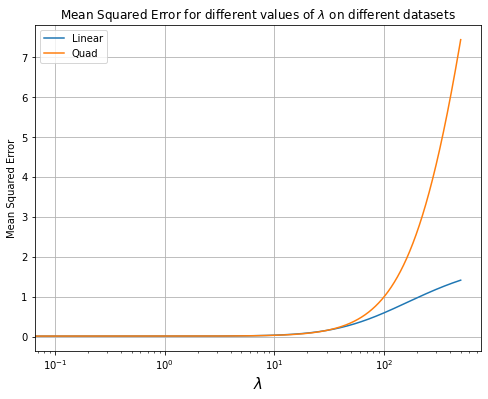

In [ ]:
lamb = np.array([lam for lam in np.arange(0, 500, 0.1)])
mselin = []
msequ = []
for la in lamb:
    lin_reg = RidgeRegression(lambda_=la, ftype='lin')
    lin_reg.fit(X_lin, y_lin)
    yhat_l = lin_reg.predict(X_lin)
    mselin.append(MSE(yhat_l, y_lin))

    quad_reg = RidgeRegression(lambda_=la, ftype='quad')
    quad_reg.fit(X_quad, y_quad)
    yhat_q = quad_reg.predict(X_quad)
    msequ.append(MSE(yhat_q, y_quad))

mselin_min_idx = np.argmin(mselin)
msequ_min_idx = np.argmin(msequ)
print(f"For Linear dataset --> MSE minimum = {mselin[mselin_min_idx]}\t lambda = {lamb[mselin_min_idx]}")
print(f"For Quadratic dataset --> MSE minimum = {msequ[msequ_min_idx]}\t lambda = {lamb[msequ_min_idx]}")

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lamb, mselin, label='Linear')
ax.plot(lamb, msequ, label='Quad')
ax.set_xscale('log')
ax.set_title("Mean Squared Error for different values of $\lambda$ on different datasets")
ax.set_xlabel('$\lambda$', fontsize=15)
ax.set_ylabel('Mean Squared Error')
ax.legend()
ax.grid()

6) *(5 points)* Evaluate the quadratic dataset `(X_quad, y_quad)` for different values of `lambda_`. Report the MSE on the full data set when trained on the partial dataset `(X_quad_train, y_quad_train)`. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. print the minimal `lambda_`.

Plot the surface and data points of the best `lambda_` value using the function `plot_data_and_model`.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


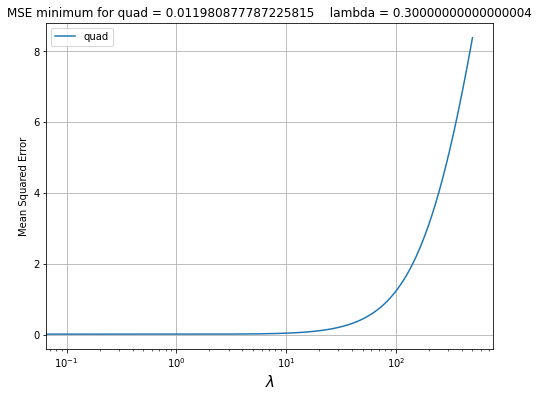

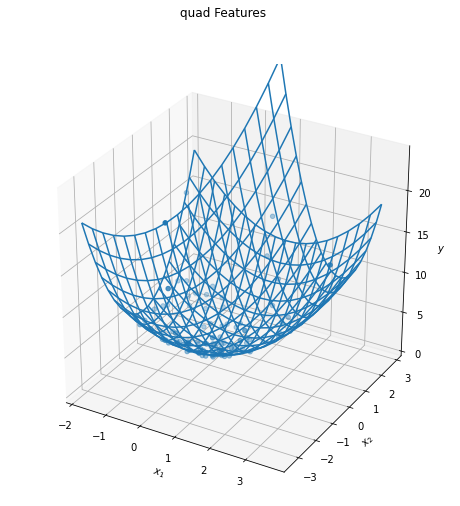

In [ ]:
# Implement your solution here.
lamb = np.array([lam for lam in np.arange(0, 500, 0.1)])
msequ = []
for la in lamb:
    quad_reg = RidgeRegression(lambda_=la, ftype='quad')
    quad_reg.fit(X_quad_train, y_quad_train)
    yhat = quad_reg.predict(X_quad)
    msequ.append(MSE(yhat, y_quad))
    

msequ_min_idx = np.argmin(msequ)
title = f"MSE minimum for quad = {msequ[msequ_min_idx]}    lambda = {lamb[msequ_min_idx]}"

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lamb, msequ, label='quad')
ax.set_xscale('log')
ax.set_title(title)
ax.set_xlabel('$\lambda$', fontsize=15)
ax.set_ylabel('Mean Squared Error')
ax.legend()
ax.grid()

qu_reg = RidgeRegression(lambda_=lamb[msequ_min_idx], ftype='quad')
train_evaluate(qu_reg, X_quad_train, y_quad_train)
plot_data_and_model(qu_reg, X_quad, y_quad)

7) *(5 points)* Evaluate the noisy dataset `(X_noise, y_noise)` for different values of `lambda_`. Report the MSE on the full data set when trained on the partial dataset `(X_noise_train, y_noise_train)`. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis.

Plot the surface and data points of the best `lambda_` value using the function `plot_data_and_model`.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


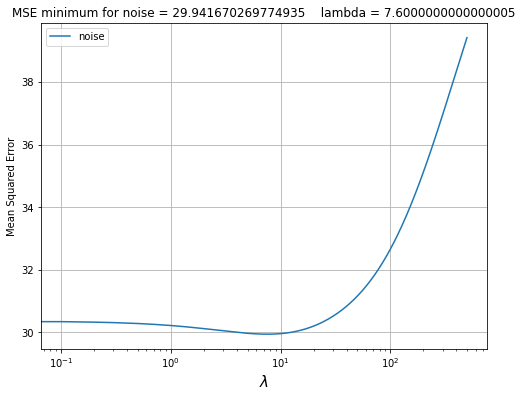

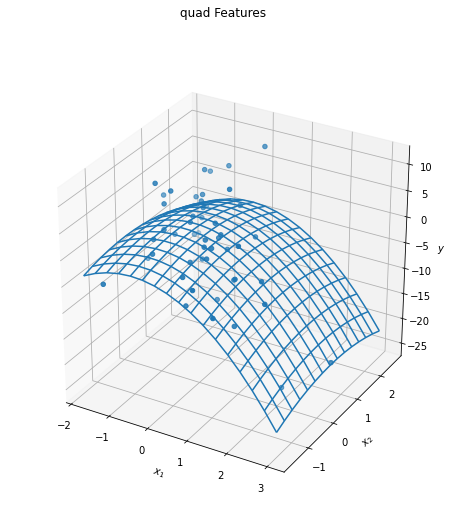

In [ ]:
# Implement your solution here.
lamb = np.array([lam for lam in np.arange(0, 500, 0.1)])
mse_no = []
for la in lamb:
    quad_reg = RidgeRegression(lambda_=la, ftype='quad')
    quad_reg.fit(X_noise_train, y_noise_train)
    yhat = quad_reg.predict(X_noise)
    mse_no.append(MSE(yhat, y_noise))
    

mse_no_min_idx = np.argmin(mse_no)
title = f"MSE minimum for noise = {mse_no[mse_no_min_idx]}    lambda = {lamb[mse_no_min_idx]}"

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lamb, mse_no, label='noise')
ax.set_xscale('log')
ax.set_title(title)
ax.set_xlabel('$\lambda$', fontsize=15)
ax.set_ylabel('Mean Squared Error')
ax.legend()
ax.grid()

noise_reg = RidgeRegression(lambda_=lamb[mse_no_min_idx], ftype='quad')
train_evaluate(noise_reg, X_noise_train, y_noise_train)
plot_data_and_model(noise_reg, X_noise, y_noise)

## Task 3 Evaluation (20 points)

1) *(5 points)* What was the best choice for regularization term `lambda_` in the models above? Explain the observation from the previous task? If `lambda_` is set to zero $\hat{\beta}$ is not regularized, when would $\lambda = 0$ be a good choice?

==>
* Linear model - lambda_ = 0
* Quad model - lambda_ = 0.3
* Noise model - lambda_ = 7.60 <br>
$\lambda$ = 0 would be a good choice if the model needs to be unbiased.

**For all students other than B.Sc. Data Science:** 

2) *(15 points)* Implement the function `cross_validation` for `k_fold = 10` to evaluate the prediction error of your model. Report the mean squared error from cross-validation. Repeat this for different Ridge regularization parameters `lambda_` and generate a nice bar plot of the MSE for various `lambda_`. Plot the values of `lambda_` on the x-axis on a logarithmical scale and the error on the y-axis. 

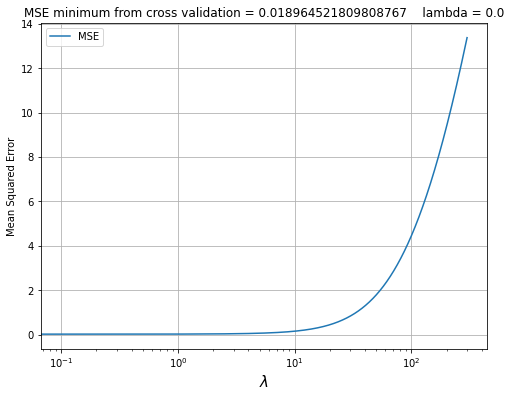

In [ ]:
def cross_validation(regression_model, X, y, k_fold = 10):
    """
    partition data X in k_fold equal sized subsets D = {D_1, ..., D_{k_fold}}, 
    fit the model on k_fold-1 subsets (D\D_i), 
    compute MSE on the evaluatin set (D_i),
    return the mean MSE over all subsets D
    """
    # D = np.array([X[i:i+k_fold,:] for i in range(0, X.shape[0], k_fold)])
    mse_ls = np.empty(k_fold)
    for i in range(k_fold):
        DX_i = X[i:i+k_fold,:]
        Dy_i = y[i:i+k_fold]
        DX = np.delete(X, slice(i, i+k_fold), axis=0)
        Dy = np.delete(y, slice(i, i+k_fold), axis=0)
        regression_model.fit(DX, Dy)
        yhat = regression_model.predict(DX_i)
        mse_ls[i] = MSE(yhat, Dy_i)
    
    mse_av = mse_ls.mean()
    return mse_av


lamb = np.array([lam for lam in np.arange(0, 300, 0.1)])
mse_av = []
for la in lamb:
    reg_obj = RidgeRegression(lambda_=la, ftype='quad')
    err = cross_validation(reg_obj, X_quad, y_quad, k_fold=10)
    mse_av.append(err)
    

mse_av_min_idx = np.argmin(mse_av)
title = f"MSE minimum from cross validation = {mse_av[mse_av_min_idx]}    lambda = {lamb[mse_av_min_idx]}"


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lamb, mse_av, label='MSE')
ax.set_xscale('log')
ax.set_title(title)
ax.set_xlabel('$\lambda$', fontsize=15)
ax.set_ylabel('Mean Squared Error')
ax.legend()
ax.grid()